# Détectez des faux billets avec Python

#### Importing Libraries

In [1]:
# Data manipulation
import numpy as np
import pandas as pd
import numpy 

# Statistics
import statsmodels
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols

import scipy
import scipy.stats as st
from scipy import stats
from scipy.stats import chi2_contingency
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.stats import skew, kurtosis

import sklearn
from sklearn import decomposition
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans


import datetime as dt
%matplotlib inline

# Graphics
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib import pyplot

#### Importing Data

In [2]:
billet=pd.read_csv("billets.csv", sep=";", decimal=',')
billet

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.5,4.4,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54
...,...,...,...,...,...,...,...
1495,False,171.75,104.38,104.17,4.42,3.09,111.28
1496,False,172.19,104.63,104.44,5.27,3.37,110.97
1497,False,171.8,104.01,104.12,5.51,3.36,111.95
1498,False,172.06,104.28,104.06,5.17,3.46,112.25


## Mission 1
### Descriptive Analysis of the Data

In [3]:
billet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   is_genuine    1500 non-null   bool  
 1   diagonal      1500 non-null   object
 2   height_left   1500 non-null   object
 3   height_right  1500 non-null   object
 4   margin_low    1463 non-null   object
 5   margin_up     1500 non-null   object
 6   length        1500 non-null   object
dtypes: bool(1), object(6)
memory usage: 71.9+ KB


In [4]:
billet['diagonal'] = billet['diagonal'].astype('float64')
billet['height_left'] = billet['height_left'].astype('float64')
billet['height_right'] = billet['height_right'].astype('float64')
billet['margin_low'] = billet['margin_low'].astype('float64')
billet['margin_up'] = billet['margin_up'].astype('float64')
billet['length'] = billet['length'].astype('float64')

In [5]:
billet['is_genuine'].unique()

array([ True, False])

#### Quick Descriptions
*Our is_genuine variable takes two possible values:*

    - The True value corresponding to a vrai ticket.
    - The False value corresponding to an faux ticket, that is to say a fake ticket.

*Number of true tickets*

In [6]:
# Number of true banknotes:
Vrais = billet.loc[billet['is_genuine'].isin([True]),:]

In [7]:
nb_vrais = np.sum(billet["is_genuine"])
print("We have {} banknotes that are true".format(nb_vrais))

We have 1000 banknotes that are true


In [8]:
Vrais.count()

is_genuine      1000
diagonal        1000
height_left     1000
height_right    1000
margin_low       971
margin_up       1000
length          1000
dtype: int64

In [9]:
Vrais.describe().round(2)

,diagonal,height_left,height_right,margin_low,margin_up,length
count,1000.00,1000.00,1000.00,971.00,1000.00,1000.00
mean,171.99,103.95,103.81,4.12,3.05,113.20
std,0.30,0.30,0.29,0.32,0.19,0.36
min,171.04,103.14,102.82,2.98,2.27,111.76
25%,171.79,103.74,103.61,3.90,2.93,112.95
50%,171.99,103.95,103.81,4.11,3.05,113.20
75%,172.20,104.14,104.00,4.34,3.18,113.46
max,172.92,104.86,104.95,5.04,3.74,114.44


In [10]:
# Number of false banknotes:
Faux = billet.loc[billet['is_genuine'].isin([False]),:]

In [11]:
nb_faux = np.sum(~billet["is_genuine"])
print("We have {} banknotes that are false".format(nb_faux))

We have 500 banknotes that are false


In [12]:
Faux.count()

is_genuine      500
diagonal        500
height_left     500
height_right    500
margin_low      492
margin_up       500
length          500
dtype: int64

In [13]:
Faux.describe().round(2)

,diagonal,height_left,height_right,margin_low,margin_up,length
count,500.00,500.00,500.00,492.00,500.00,500.00
mean,171.90,104.19,104.14,5.22,3.35,111.63
std,0.31,0.22,0.27,0.55,0.18,0.62
min,171.04,103.51,103.43,3.82,2.92,109.49
25%,171.69,104.04,103.95,4.84,3.22,111.20
50%,171.91,104.18,104.16,5.19,3.35,111.63
75%,172.09,104.33,104.32,5.59,3.47,112.03
max,173.01,104.88,104.95,6.90,3.91,113.85


In [14]:
# Average of our sample of true banknotes:
true_average = (nb_vrais/(nb_vrais + nb_faux))*100
print("Our sample has an average of {}% true banknotes.".format(true_average))

Our sample has an average of 66.66666666666666% true banknotes.


**Quick description of variables:**

    * We have data for 1500 tickets
    * 1000 tickets that are true
    * 500 tickets that are false
    * In average 66.67% of the banknotes in the sample is true

In [15]:
billet.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54


In [16]:
billet.describe().round(2)

,diagonal,height_left,height_right,margin_low,margin_up,length
count,1500.00,1500.00,1500.00,1463.00,1500.00,1500.00
mean,171.96,104.03,103.92,4.49,3.15,112.68
std,0.31,0.30,0.33,0.66,0.23,0.87
min,171.04,103.14,102.82,2.98,2.27,109.49
25%,171.75,103.82,103.71,4.01,2.99,112.03
50%,171.96,104.04,103.92,4.31,3.14,112.96
75%,172.17,104.23,104.15,4.87,3.31,113.34
max,173.01,104.88,104.95,6.90,3.91,114.44


The standard deviations are small.

In [17]:
billet.iloc[:,1:].corr().round(2)

,diagonal,height_left,height_right,margin_low,margin_up,length
diagonal,1.00,0.02,-0.02,-0.11,-0.06,0.10
height_left,0.02,1.00,0.24,0.30,0.25,-0.32
height_right,-0.02,0.24,1.00,0.39,0.31,-0.40
margin_low,-0.11,0.30,0.39,1.00,0.43,-0.67
margin_up,-0.06,0.25,0.31,0.43,1.00,-0.52
length,0.10,-0.32,-0.40,-0.67,-0.52,1.00


Quick description of the correlations.

**Comments:**

    * Moderate negative correlation (-0.67) between bottom margin and length.
    * Moderate negative correlation (-0.52) between up margin and length.
    * Weak positive correlation (0.43) between up margin and bottom margin.

In [18]:
billet.shape

(1500, 7)

In [19]:
billet.isnull().sum()

is_genuine       0
diagonal         0
height_left      0
height_right     0
margin_low      37
margin_up        0
length           0
dtype: int64

There are 37 null values for the column margin_low. In order to replace those null values, **linear regression is applied**.

### Data Cleaning
#### Linear Regression to Replace NaN Values

In [20]:
### Seperate the null values from dataframe and create a variable called 'test_data'
test_data = billet[billet['margin_low'].isnull()]
test_data

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
72,True,171.94,103.89,103.45,NaN,3.25,112.79
99,True,171.93,104.07,104.18,NaN,3.14,113.08
151,True,172.07,103.80,104.38,NaN,3.02,112.93
197,True,171.45,103.66,103.80,NaN,3.62,113.27
241,True,171.83,104.14,104.06,NaN,3.02,112.36
251,True,171.80,103.26,102.82,NaN,2.95,113.22
284,True,171.92,103.83,103.76,NaN,3.23,113.29
334,True,171.85,103.70,103.96,NaN,3.00,113.36
410,True,172.56,103.72,103.51,NaN,3.12,112.95
413,True,172.30,103.66,103.50,NaN,3.16,112.95


In [21]:
test_data.shape

(37, 7)

In [22]:
### Drop the null values from the dataframe and represent as 'train_data'
train_data = billet.dropna()
train_data

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54
...,...,...,...,...,...,...,...
1495,False,171.75,104.38,104.17,4.42,3.09,111.28
1496,False,172.19,104.63,104.44,5.27,3.37,110.97
1497,False,171.80,104.01,104.12,5.51,3.36,111.95
1498,False,172.06,104.28,104.06,5.17,3.46,112.25


In [23]:
train_data.shape

(1463, 7)

In [24]:
### Create 'x_train' & 'y_train' from train_data
x_train = train_data.drop('margin_low', axis = 1)
x_train

,is_genuine,diagonal,height_left,height_right,margin_up,length
0,True,171.81,104.86,104.95,2.89,112.83
1,True,171.46,103.36,103.66,2.99,113.09
2,True,172.69,104.48,103.50,2.94,113.16
3,True,171.36,103.91,103.94,3.01,113.51
4,True,171.73,104.28,103.46,3.48,112.54
...,...,...,...,...,...,...
1495,False,171.75,104.38,104.17,3.09,111.28
1496,False,172.19,104.63,104.44,3.37,110.97
1497,False,171.80,104.01,104.12,3.36,111.95
1498,False,172.06,104.28,104.06,3.46,112.25


In [25]:
### Create 'x_train' & 'y_train' from train_data
y_train = train_data['margin_low']
y_train

0       4.52
1       3.77
2       4.40
3       3.62
4       4.04
        ... 
1495    4.42
1496    5.27
1497    5.51
1498    5.17
1499    4.63
Name: margin_low, Length: 1463, dtype: float64

In [26]:
### Build the Linear Regression Model
from sklearn.linear_model import LinearRegression
lr = LinearRegression()

In [27]:
lr.fit(x_train, y_train)

LinearRegression()

In [28]:
### Create x_test from the test_data
x_test = test_data[['is_genuine', 'diagonal', 'height_left', 'height_right', 'margin_up', 'length']]
x_test

,is_genuine,diagonal,height_left,height_right,margin_up,length
72,True,171.94,103.89,103.45,3.25,112.79
99,True,171.93,104.07,104.18,3.14,113.08
151,True,172.07,103.80,104.38,3.02,112.93
197,True,171.45,103.66,103.80,3.62,113.27
241,True,171.83,104.14,104.06,3.02,112.36
251,True,171.80,103.26,102.82,2.95,113.22
284,True,171.92,103.83,103.76,3.23,113.29
334,True,171.85,103.70,103.96,3.00,113.36
410,True,172.56,103.72,103.51,3.12,112.95
413,True,172.30,103.66,103.50,3.16,112.95


In [29]:
### Apply the model on x_test of test_data to make predictions
y_pred = lr.predict(x_test)
y_pred

array([4.06495361, 4.11199026, 4.13400328, 3.99357074, 4.1403993 ,
       4.09428392, 4.07412432, 4.12538999, 4.0807278 , 4.07363322,
       4.11897255, 4.18037978, 4.13648423, 4.05106842, 4.17837685,
       4.22555104, 4.11586845, 4.10284101, 4.08184346, 4.09276238,
       4.11250192, 4.15717623, 4.16028787, 4.12193808, 4.12353555,
       4.19842271, 4.10962313, 4.09696025, 4.13384101, 5.25968515,
       5.264817  , 5.28251853, 5.30206887, 5.20035843, 5.1754678 ,
       5.17345045, 5.24675055])

In [30]:
pd.options.mode.chained_assignment = None  # default='warn'

In [31]:
test_data['margin_low_new'] = y_pred

In [32]:
test_data

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length,margin_low_new
72,True,171.94,103.89,103.45,NaN,3.25,112.79,4.064954
99,True,171.93,104.07,104.18,NaN,3.14,113.08,4.111990
151,True,172.07,103.80,104.38,NaN,3.02,112.93,4.134003
197,True,171.45,103.66,103.80,NaN,3.62,113.27,3.993571
241,True,171.83,104.14,104.06,NaN,3.02,112.36,4.140399
251,True,171.80,103.26,102.82,NaN,2.95,113.22,4.094284
284,True,171.92,103.83,103.76,NaN,3.23,113.29,4.074124
334,True,171.85,103.70,103.96,NaN,3.00,113.36,4.125390
410,True,172.56,103.72,103.51,NaN,3.12,112.95,4.080728
413,True,172.30,103.66,103.50,NaN,3.16,112.95,4.073633


In [33]:
A = test_data.drop('margin_low', axis = 1)
A

,is_genuine,diagonal,height_left,height_right,margin_up,length,margin_low_new
72,True,171.94,103.89,103.45,3.25,112.79,4.064954
99,True,171.93,104.07,104.18,3.14,113.08,4.111990
151,True,172.07,103.80,104.38,3.02,112.93,4.134003
197,True,171.45,103.66,103.80,3.62,113.27,3.993571
241,True,171.83,104.14,104.06,3.02,112.36,4.140399
251,True,171.80,103.26,102.82,2.95,113.22,4.094284
284,True,171.92,103.83,103.76,3.23,113.29,4.074124
334,True,171.85,103.70,103.96,3.00,113.36,4.125390
410,True,172.56,103.72,103.51,3.12,112.95,4.080728
413,True,172.30,103.66,103.50,3.16,112.95,4.073633


In [34]:
# Renaming columns
A = A.set_axis(['is_genuine', 'diagonal', 'height_left', 'height_right', 'margin_up', 'length', 'margin_low'], axis=1, inplace=False)
A

,is_genuine,diagonal,height_left,height_right,margin_up,length,margin_low
72,True,171.94,103.89,103.45,3.25,112.79,4.064954
99,True,171.93,104.07,104.18,3.14,113.08,4.111990
151,True,172.07,103.80,104.38,3.02,112.93,4.134003
197,True,171.45,103.66,103.80,3.62,113.27,3.993571
241,True,171.83,104.14,104.06,3.02,112.36,4.140399
251,True,171.80,103.26,102.82,2.95,113.22,4.094284
284,True,171.92,103.83,103.76,3.23,113.29,4.074124
334,True,171.85,103.70,103.96,3.00,113.36,4.125390
410,True,172.56,103.72,103.51,3.12,112.95,4.080728
413,True,172.30,103.66,103.50,3.16,112.95,4.073633


In [35]:
# Shifting columns into desired places
fifth_column = A.pop('margin_low')
A.insert(4, 'margin_low', fifth_column)
A

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
72,True,171.94,103.89,103.45,4.064954,3.25,112.79
99,True,171.93,104.07,104.18,4.111990,3.14,113.08
151,True,172.07,103.80,104.38,4.134003,3.02,112.93
197,True,171.45,103.66,103.80,3.993571,3.62,113.27
241,True,171.83,104.14,104.06,4.140399,3.02,112.36
251,True,171.80,103.26,102.82,4.094284,2.95,113.22
284,True,171.92,103.83,103.76,4.074124,3.23,113.29
334,True,171.85,103.70,103.96,4.125390,3.00,113.36
410,True,172.56,103.72,103.51,4.080728,3.12,112.95
413,True,172.30,103.66,103.50,4.073633,3.16,112.95


In [36]:
# Final data is created with the calculated null values:
frames = [train_data, A]
data = pd.concat(frames)
data

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.520000,2.89,112.83
1,True,171.46,103.36,103.66,3.770000,2.99,113.09
2,True,172.69,104.48,103.50,4.400000,2.94,113.16
3,True,171.36,103.91,103.94,3.620000,3.01,113.51
4,True,171.73,104.28,103.46,4.040000,3.48,112.54
...,...,...,...,...,...,...,...
1303,False,172.17,104.49,103.76,5.302069,2.93,111.21
1315,False,172.08,104.15,104.17,5.200358,3.40,112.29
1347,False,171.72,104.46,104.12,5.175468,3.61,110.31
1435,False,172.66,104.33,104.41,5.173450,3.56,111.47


### Descriptive Analysis of the Final Data

In [37]:
data.isnull().sum()

is_genuine      0
diagonal        0
height_left     0
height_right    0
margin_low      0
margin_up       0
length          0
dtype: int64

There are no null values.

In [38]:
data.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54


In [39]:
data.describe().round(2)

,diagonal,height_left,height_right,margin_low,margin_up,length
count,1500.00,1500.00,1500.00,1500.00,1500.00,1500.00
mean,171.96,104.03,103.92,4.48,3.15,112.68
std,0.31,0.30,0.33,0.66,0.23,0.87
min,171.04,103.14,102.82,2.98,2.27,109.49
25%,171.75,103.82,103.71,4.03,2.99,112.03
50%,171.96,104.04,103.92,4.31,3.14,112.96
75%,172.17,104.23,104.15,4.87,3.31,113.34
max,173.01,104.88,104.95,6.90,3.91,114.44


The standard deviations are remained small.

In [40]:
data.iloc[:,1:].corr().round(2)

,diagonal,height_left,height_right,margin_low,margin_up,length
diagonal,1.00,0.02,-0.02,-0.11,-0.06,0.10
height_left,0.02,1.00,0.24,0.31,0.25,-0.32
height_right,-0.02,0.24,1.00,0.39,0.31,-0.40
margin_low,-0.11,0.31,0.39,1.00,0.43,-0.67
margin_up,-0.06,0.25,0.31,0.43,1.00,-0.52
length,0.10,-0.32,-0.40,-0.67,-0.52,1.00


* Moderate negative correlation (-0.67) between low margin and length.
* Moderate negative correlation (-0.52) between up margin and length.
* Weak positive correlation (0.43) between up margin and low margin.

In [41]:
# The colors of our banknotes
# The true banknotes in green
# False banknotes in red
# When using a palette
colors = ["medium green", "pale red"]
my_palette = sns.xkcd_palette(colors)
# When we want the name of a variable
green = sns.xkcd_rgb["medium green"] #39ad48
red = sns.xkcd_rgb["pale red"] #d9544d

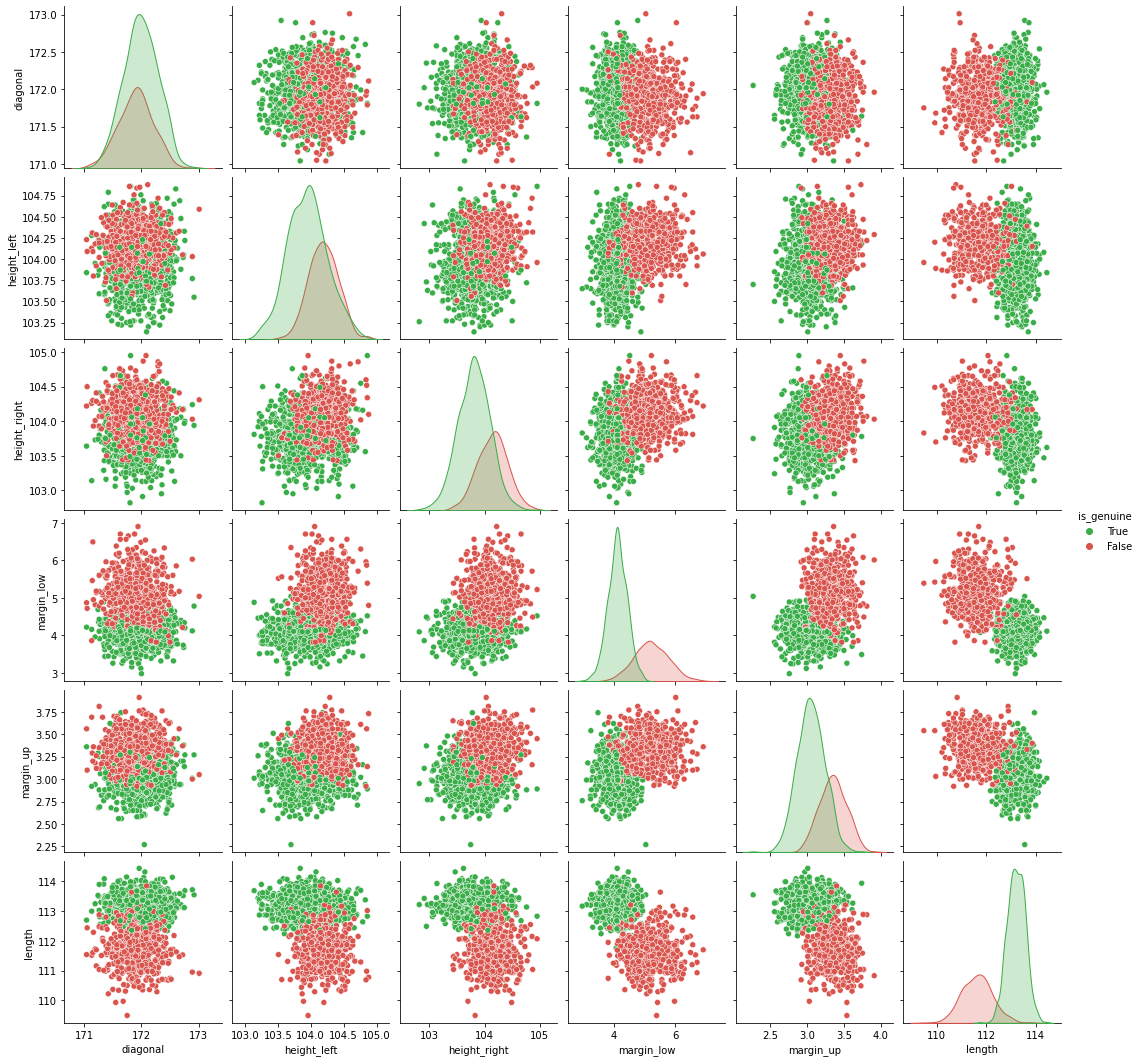

In [42]:
# Creating a temporary table
# We change the type of the true column
# from a "numpy.boolean" type to a "str" type
data_str = data.copy()
data_str.iloc[:,0] = data_str.iloc[:,0].astype(str)

# We plot.
g = sns.pairplot(data_str, hue="is_genuine",palette=my_palette)

**Graphical analysis of the pairplot:**

    - The plots related to the low margin show that false banknotes have higher low margins than true banknotes.
    - The plots related to the up margin show that false banknotes have higher up margins than true banknotes.
    - The plots related to the length show that the false banknotes have lower lengths than the true banknotes.

#### ANOVA test to verify our graphical analyses.

    H0: Means of true and false banknotes are equal
    H1: Means they are not equal

<AxesSubplot:title={'center':'diagonal'}, xlabel='is_genuine'>

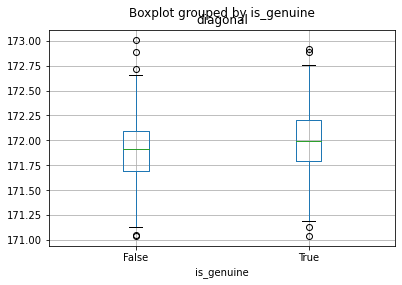

In [43]:
data.boxplot('diagonal', by='is_genuine')

In [44]:
# Quantitative variable
x = "diagonal"
# Qualitative variable
y = "is_genuine"

sample0 = data[x][data[y]]
sample1 = data[x][~data[y]]

FSTAT, pvalue = scipy.stats.f_oneway(sample0, sample1)
print("FSTAT = {}, pvalue = {}".format(
    round(FSTAT, 2),
    round(pvalue, 2)))
if pvalue < 0.05:
    print("We reject H0.\nTrue banknotes do not have the same average as false banknotes for variable x: {} at 95% confidence level".format(x))
else:
    print("We cannot reject H0. The means are identical at a confidence level of 95%.")

FSTAT = 26.87, pvalue = 0.0
We reject H0.
True banknotes do not have the same average as false banknotes for variable x: diagonal at 95% confidence level


<AxesSubplot:title={'center':'height_left'}, xlabel='is_genuine'>

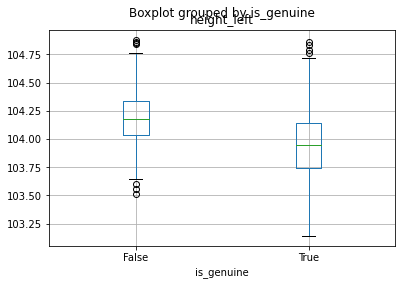

In [45]:
data.boxplot(column='height_left',by='is_genuine')

In [46]:
# Quantitative variable
x = "height_left"
# Qualitative variable
y = "is_genuine"

sample0 = data[x][data[y]]
sample1 = data[x][~data[y]]

FSTAT, pvalue = scipy.stats.f_oneway(sample0, sample1)
print("FSTAT = {}, pvalue = {}".format(
    round(FSTAT, 2),
    round(pvalue, 2)))
if pvalue < 0.05:
    print("We reject H0.\nTrue banknotes do not have the same average as false banknotes for variable x: {} at 95% confidence level".format(x))
else:
    print("We cannot reject H0. The means are identical at a confidence level of 95%.")

FSTAT = 252.56, pvalue = 0.0
We reject H0.
True banknotes do not have the same average as false banknotes for variable x: height_left at 95% confidence level


<AxesSubplot:title={'center':'height_right'}, xlabel='is_genuine'>

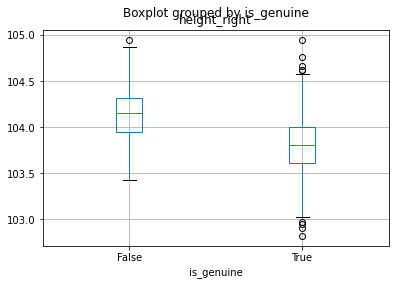

In [47]:
data.boxplot(column='height_right',by='is_genuine')

In [48]:
# Quantitative variable
x = "height_right"
# Qualitative variable
y = "is_genuine"

sample0 = data[x][data[y]]
sample1 = data[x][~data[y]]

FSTAT, pvalue = scipy.stats.f_oneway(sample0, sample1)
print("FSTAT = {}, pvalue = {}".format(
    round(FSTAT, 2),
    round(pvalue, 2)))
if pvalue < 0.05:
    print("We reject H0.\nTrue banknotes do not have the same average as false banknotes for variable x: {} at 95% confidence level".format(x))
else:
    print("We cannot reject H0. The means are identical at a confidence level of 95%.")

FSTAT = 460.97, pvalue = 0.0
We reject H0.
True banknotes do not have the same average as false banknotes for variable x: height_right at 95% confidence level


<AxesSubplot:title={'center':'margin_low'}, xlabel='is_genuine'>

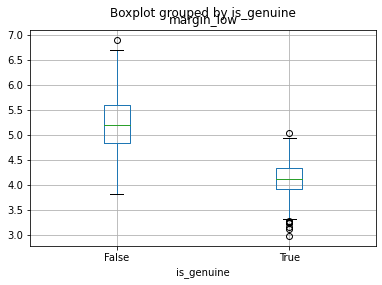

In [49]:
data.boxplot(column='margin_low',by='is_genuine')

In [50]:
# Quantitative variable
x = "margin_low"
# Qualitative variable
y = "is_genuine"

sample0 = data[x][data[y]]
sample1 = data[x][~data[y]]

FSTAT, pvalue = scipy.stats.f_oneway(sample0, sample1)
print("FSTAT = {}, pvalue = {}".format(
    round(FSTAT, 2),
    round(pvalue, 2)))
if pvalue < 0.05:
    print("We reject H0.\nTrue banknotes do not have the same average as false banknotes for variable x: {} at 95% confidence level".format(x))
else:
    print("We cannot reject H0. The means are identical at a confidence level of 95%.")

FSTAT = 2424.22, pvalue = 0.0
We reject H0.
True banknotes do not have the same average as false banknotes for variable x: margin_low at 95% confidence level


<AxesSubplot:title={'center':'margin_up'}, xlabel='is_genuine'>

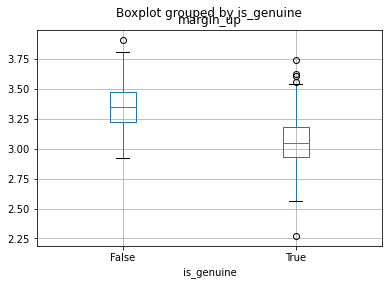

In [51]:
data.boxplot(column='margin_up',by='is_genuine')

In [52]:
# Quantitative variable
x = "margin_up"
# Qualitative variable
y = "is_genuine"

sample0 = data[x][data[y]]
sample1 = data[x][~data[y]]

FSTAT, pvalue = scipy.stats.f_oneway(sample0, sample1)
print("FSTAT = {}, pvalue = {}".format(
    round(FSTAT, 2),
    round(pvalue, 2)))
if pvalue < 0.05:
    print("We reject H0.\nTrue banknotes do not have the same average as false banknotes for variable x: {} at 95% confidence level".format(x))
else:
    print("We cannot reject H0. The means are identical at a confidence level of 95%.")

FSTAT = 870.58, pvalue = 0.0
We reject H0.
True banknotes do not have the same average as false banknotes for variable x: margin_up at 95% confidence level


<AxesSubplot:title={'center':'length'}, xlabel='is_genuine'>

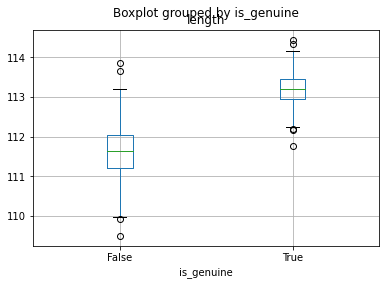

In [53]:
data.boxplot(column='length',by='is_genuine')

In [54]:
# Quantitative variable
x = "length"
# Qualitative variable
y = "is_genuine"

sample0 = data[x][data[y]]
sample1 = data[x][~data[y]]

FSTAT, pvalue = scipy.stats.f_oneway(sample0, sample1)
print("FSTAT = {}, pvalue = {}".format(
    round(FSTAT, 2),
    round(pvalue, 2)))
if pvalue < 0.05:
    print("We reject H0.\nTrue banknotes do not have the same average as false banknotes for variable x: {} at 95% confidence level".format(x))
else:
    print("We cannot reject H0. The means are identical at a confidence level of 95%.")

FSTAT = 3876.65, pvalue = 0.0
We reject H0.
True banknotes do not have the same average as false banknotes for variable x: length at 95% confidence level


In [55]:
data.groupby(by='is_genuine').mean().round(2)

,diagonal,height_left,height_right,margin_low,margin_up,length
is_genuine,,,,,,
False,171.90,104.19,104.14,5.22,3.35,111.63
True,171.99,103.95,103.81,4.12,3.05,113.20


**Comments:**

    - Diagonal     : Nothing very noteworthy
    - Left height  : Nothing very noteworthy
    - Right height : Nothing very noteworthy
    - High Margin  : Nothing very noteworthy
    - Lower Margin : A significant difference
    - Length       : A significant difference

### Simple Linear Regression

In [56]:
reg_simp = smf.ols('margin_low ~ length', data=data).fit()

In [57]:
print(reg_simp.summary())

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.447
Model:                            OLS   Adj. R-squared:                  0.446
Method:                 Least Squares   F-statistic:                     1210.
Date:                Mon, 29 Aug 2022   Prob (F-statistic):          7.87e-195
Time:                        14:29:41   Log-Likelihood:                -1060.4
No. Observations:                1500   AIC:                             2125.
Df Residuals:                    1498   BIC:                             2135.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     61.4343      1.637     37.522      0.0

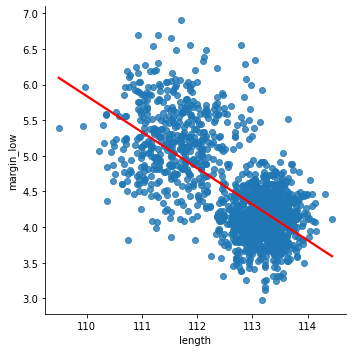

In [58]:
ax = sns.lmplot(x="length", y="margin_low", data=data, ci=None, line_kws={'color':'red'})
ax.set(xlabel='length', ylabel='margin_low')
plt.show()

### Multiple Linear Regression

In [59]:
from scipy.stats import t, shapiro
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels
from functions import *

In [60]:
reg_multi = smf.ols('length~diagonal+height_left+height_right+margin_low+margin_up', data=data).fit()

In [61]:
print(reg_multi.summary())

                            OLS Regression Results                            
Dep. Variable:                 length   R-squared:                       0.532
Model:                            OLS   Adj. R-squared:                  0.531
Method:                 Least Squares   F-statistic:                     340.0
Date:                Mon, 29 Aug 2022   Prob (F-statistic):          2.00e-243
Time:                        14:29:42   Log-Likelihood:                -1353.9
No. Observations:                1500   AIC:                             2720.
Df Residuals:                    1494   BIC:                             2752.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept      160.6110     11.147     14.408   

In [62]:
reg_multi_2 = smf.ols('diagonal~length+height_left+height_right+margin_low+margin_up', data=data).fit()

In [63]:
print(reg_multi_2.summary())

                            OLS Regression Results                            
Dep. Variable:               diagonal   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     5.351
Date:                Mon, 29 Aug 2022   Prob (F-statistic):           6.99e-05
Time:                        14:29:42   Log-Likelihood:                -334.39
No. Observations:                1500   AIC:                             680.8
Df Residuals:                    1494   BIC:                             712.7
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept      160.6991      4.366     36.808   

In [64]:
reg_multi_3 = smf.ols('height_left~length+diagonal+height_right+margin_low+margin_up', data=data).fit()

In [65]:
print(reg_multi_3.summary())

                            OLS Regression Results                            
Dep. Variable:            height_left   R-squared:                       0.137
Model:                            OLS   Adj. R-squared:                  0.134
Method:                 Least Squares   F-statistic:                     47.52
Date:                Mon, 29 Aug 2022   Prob (F-statistic):           1.05e-45
Time:                        14:29:42   Log-Likelihood:                -208.57
No. Observations:                1500   AIC:                             429.1
Df Residuals:                    1494   BIC:                             461.0
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       89.6697      5.035     17.809   

In [66]:
reg_multi_4 = smf.ols('height_right~length+diagonal+height_left+margin_low+margin_up', data=data).fit()

In [67]:
print(reg_multi_4.summary())

                            OLS Regression Results                            
Dep. Variable:           height_right   R-squared:                       0.206
Model:                            OLS   Adj. R-squared:                  0.203
Method:                 Least Squares   F-statistic:                     77.54
Date:                Mon, 29 Aug 2022   Prob (F-statistic):           2.06e-72
Time:                        14:29:42   Log-Likelihood:                -271.87
No. Observations:                1500   AIC:                             555.7
Df Residuals:                    1494   BIC:                             587.6
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      96.7011      5.214     18.548      

In [68]:
reg_multi_5 = smf.ols('margin_low~length+diagonal+height_left+height_right+margin_up', data=data).fit()

In [69]:
print(reg_multi_5.summary())

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.479
Model:                            OLS   Adj. R-squared:                  0.478
Method:                 Least Squares   F-statistic:                     275.2
Date:                Mon, 29 Aug 2022   Prob (F-statistic):          7.84e-209
Time:                        14:29:42   Log-Likelihood:                -1014.7
No. Observations:                1500   AIC:                             2041.
Df Residuals:                    1494   BIC:                             2073.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       23.2304      9.470      2.453   

In [70]:
reg_multi_6 = smf.ols('margin_up~length+diagonal+height_left+height_right+margin_low', data=data).fit()

In [71]:
print(reg_multi_6.summary())

                            OLS Regression Results                            
Dep. Variable:              margin_up   R-squared:                       0.295
Model:                            OLS   Adj. R-squared:                  0.292
Method:                 Least Squares   F-statistic:                     124.8
Date:                Mon, 29 Aug 2022   Prob (F-statistic):          1.54e-110
Time:                        14:29:42   Log-Likelihood:                 326.54
No. Observations:                1500   AIC:                            -641.1
Df Residuals:                    1494   BIC:                            -609.2
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        3.0717      3.880      0.792   

In [72]:
reg_multi_7 = smf.ols('length~margin_low+margin_up', data=data).fit()

In [73]:
print(reg_multi_7.summary())

                            OLS Regression Results                            
Dep. Variable:                 length   R-squared:                       0.514
Model:                            OLS   Adj. R-squared:                  0.513
Method:                 Least Squares   F-statistic:                     790.5
Date:                Mon, 29 Aug 2022   Prob (F-statistic):          4.95e-235
Time:                        14:29:42   Log-Likelihood:                -1383.1
No. Observations:                1500   AIC:                             2772.
Df Residuals:                    1497   BIC:                             2788.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    119.3086      0.215    554.722      0.0

## Mission 2
### Logistic Regression

**Properties of Logistic Regression:**

    - The dependent variable in logistical regression follows Bernoulli Distribution.
    - Estimate is done through maximum likelihood.
    - No R Square, Model fitness is calculated through Concordance, KS-Statistics.
    - Maximum Likelihood Estimate (MLE) approach.
    - The MLE is a "likelihood" maximization method.
    - From a statistical point of view, MLE sets the mean and variance as parameters in determining the specific parametric values for a given model. This set of parameters can be used for predicting the data needed in a normal distribution.

**Sigmoid Function**

The sigmoid function, also called logistical function gives an 'S' shaped curve that can take any real-valued number and map it into a value between 0 and 1. If the curve goes to positive infinity, y predicted will become 1, and if the curve goes to negative infinity, y predicted will become 0. If the output of the sigmoid function is more than 0.5, we can classify the outcome as 1 or YES, and if it is less than 0.5, we can classify it as 0 or NO. The outputcannotFor example: If the output is 0.75, we can say in terms of probability as: There is a 75 percent chance that patient will suffer from cancer.

**Binary Logistic Regression**

The target variable has only two possible outcomes such as Spam or Not Spam, Cancer or No Cancer.

**Advantages**

    - Because of its efficient and straightforward nature, doesn't require high computation power, easy to implement, easily interpretable, used widely by data analyst and scientist.
    - Also, it doesn't require scaling of features. Logistic regression provides a probability score for observations.

**Disadvantages**

    - Logistic regression is not able to handle a large number of categorical features/variables.
    - It is vulnerable to overfitting.
    - Can't solve the non-linear problem with the logistical regression that is why it requires a transformation of non-linear features.
    - Logistic regression will not perform well with independent variables that are not correlated to the target variable and are very similar or correlated to each other.

### Data preparation
#### Explanatory variables vs Explained variable

In [74]:
data

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.520000,2.89,112.83
1,True,171.46,103.36,103.66,3.770000,2.99,113.09
2,True,172.69,104.48,103.50,4.400000,2.94,113.16
3,True,171.36,103.91,103.94,3.620000,3.01,113.51
4,True,171.73,104.28,103.46,4.040000,3.48,112.54
...,...,...,...,...,...,...,...
1303,False,172.17,104.49,103.76,5.302069,2.93,111.21
1315,False,172.08,104.15,104.17,5.200358,3.40,112.29
1347,False,171.72,104.46,104.12,5.175468,3.61,110.31
1435,False,172.66,104.33,104.41,5.173450,3.56,111.47


In [75]:
from sklearn.linear_model import LogisticRegression

# Explanatory variables
X = data.iloc[:,1:7]
# Variables explained
y = data['is_genuine']

### Data separation
Separation of data between:

    - The data to train our model, 70% of our data.
    - Data to test our model, 30% of our data.

In [76]:
# random_state: seed utilisé pour la sélection aléatoire.
X_train, X_test, y_train, y_test=sklearn.model_selection.train_test_split(X,y,test_size=0.30,random_state=100)

In [77]:
# We check our data
print("Before number of false banknotes:",len(y_train[y_train==0]))
print("Before number of true banknotes:",len(y_train[y_train==1]))
print("Before proportion of false banknotes:",len(y_train[y_train==0])/len(X_train))
print("Before proportion of true banknotes:",len(y_train[y_train==1])/len(X_train))

Before number of false banknotes: 355
Before number of true banknotes: 695
Before proportion of false banknotes: 0.3380952380952381
Before proportion of true banknotes: 0.6619047619047619


#### Model development and prediction

In [78]:
# We create an object of the Logistic Regression class.
our_model = LogisticRegression()

# We create our model.
# We train it with our training data
y_train = pd.DataFrame(y_train)
y_train_array = y_train.iloc[:,0].values
our_model.fit(X_train, y_train_array)

# We make the prediction
# with .predict()
y_pred = our_model.predict(X_test)

In [79]:
our_model.classes_

array([False,  True])

In [80]:
our_model.intercept_

array([-0.02131296])

In [81]:
our_model.coef_

array([[-0.20667163, -1.44232381, -2.04881145, -3.25590925, -3.01044933,
         3.76445665]])

In [82]:
our_model.predict_proba(X)

array([[6.14831577e-01, 3.85168423e-01],
       [5.36039983e-04, 9.99463960e-01],
       [1.27199981e-02, 9.87280002e-01],
       ...,
       [9.99993603e-01, 6.39669874e-06],
       [9.99676758e-01, 3.23241926e-04],
       [9.98844156e-01, 1.15584423e-03]])

In [83]:
our_model.score(X, y)

0.9906666666666667

#### Model evaluation
**Confusion Matrix**

    - Table to visualize the performance of our model. It understands:
        The number of correct predictions
        The number of incorrect predictions

In [84]:
from sklearn import metrics

# We create an object of the metrics class.
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[141,   4],
       [  1, 304]], dtype=int64)

**Heat Map**

    We visualize this table with a heatmap

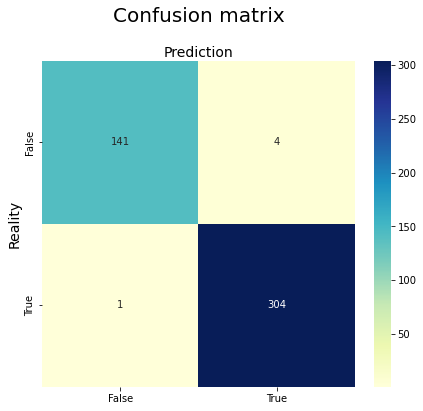

In [85]:
# Class names
fig, ax = plt.subplots(figsize=(7, 6))

# Heatmap creation
g = sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu", fmt='g')
ax.xaxis.set_label_position("top")
plt.title('Confusion matrix', y=1.1, fontsize=20)

#Axis
# Labels
ax.set_ylabel('Reality', fontsize=14)
ax.set_xlabel('Prediction', fontsize=14)

# Ticks
# Tick names
class_names=["False","True"]
#g.set(yticklabels=["Untrue","True"])
#g.set(xticklabels=["Untrue","True"])

# Tick positions
ax.tick_params(labelsize=10)
test = np.arange(len(class_names))
plt.xticks(test+0.5, class_names)
plt.yticks(test+0.5, class_names)

# We show the figure.
plt.show()

In [86]:
accuracy = round(metrics.accuracy_score(y_test, y_pred),2)
precision = round(metrics.precision_score(y_test, y_pred),2)
sensitivity = round(metrics.recall_score(y_test, y_pred),2)
specificity = round((cnf_matrix[0,0]/(cnf_matrix[0,0]+cnf_matrix[0,1])),2)

In [87]:
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Sensitivity:", sensitivity)
print("Specificity:", specificity)

Accuracy: 0.99
Precision: 0.99
Sensitivity: 1.0
Specificity: 0.97


#### ROC Curve

**The receptor efficiency function**, more commonly referred to as **"the ROC curve"**, also known as the performance characteristic (of an assay) or the sensitivity/specificity curve, is a measure of the performance of a binary classifier.

Graphically, the ROC measurement is often represented in the form of a curve which gives the rate of true positives according to the rate of false positives.

**An AUC score** of 1 represents a perfect classifier, a score of 0.5 represents a useless classifier.

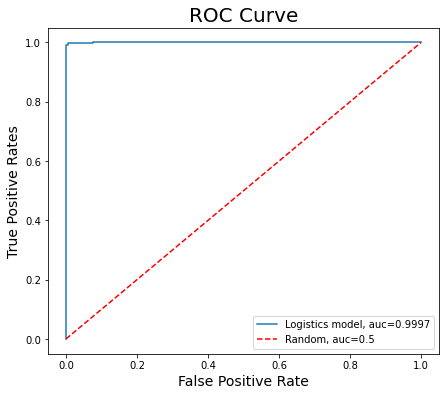

In [88]:
fig, ax = plt.subplots(figsize=(7, 6))
y_pred_proba = our_model.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
auc = round(metrics.roc_auc_score(y_test, y_pred_proba),4)
plt.plot(fpr,tpr,label="Logistics model, auc="+str(auc))
x = [0,1]
y = [0,1]
plt.plot(x,y,"r--",label="Random, auc=0.5")
plt.legend(loc=4)


plt.title('ROC Curve', fontsize=20)

#Axis
# Labels
ax.set_ylabel('True Positive Rates', fontsize=14)
ax.set_xlabel('False Positive Rate', fontsize=14)
plt.show()

#### SMOTE algorithm
**Goal:** To balance the proportion of true tickets and non-true tickets in our training data.

**Its utility:**

    - Created syntetic copies of the lowest class, instead of creating copies.
    - Randomly choose one of the k_nearest_neighbors, and use it to create new, similar but slightly modified observations

In [89]:
from imblearn.over_sampling import SMOTE

# Creation of an object of the SMOTE class.
os = SMOTE(random_state=0)

# Launching the algorithm.
os_data_X, os_data_y = os.fit_resample(X_train, y_train)

# Creation of df associated with our training values
os_data_X = pd.DataFrame(os_data_X)
os_data_y= pd.DataFrame(os_data_y)

# We check our data
print("Number of false banknotes:",len(os_data_y[os_data_y['is_genuine']==0]))
print("Number of true banknotes:",len(os_data_y[os_data_y['is_genuine']==1]))
print("Proportion of false banknotes:",len(os_data_y[os_data_y['is_genuine']==0])/len(os_data_X))
print("Proportion of true banknotes:",len(os_data_y[os_data_y['is_genuine']==1])/len(os_data_X))

Number of false banknotes: 695
Number of true banknotes: 695
Proportion of false banknotes: 0.5
Proportion of true banknotes: 0.5


In [90]:
X_train = os_data_X
y_train = os_data_y

#### Model development and prediction

In [91]:
# We create an object of the Logistic Regression class.
our_model1 = LogisticRegression()

# We create our model.
# We train it with our training data
y_train_array = y_train.iloc[:,0].values
our_model1.fit(X_train, y_train_array)

# We make the prediction
# with .predict()
y_pred = our_model1.predict(X_test)

#### Model evaluation
**Confusion Matrix**

    - Table to visualize the performance of our model. It understands:
        The number of correct predictions
        The number of incorrect predictions

In [92]:
from sklearn import metrics

# We create an object of the metrics class.
cnf_matrix1 = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix1

array([[142,   3],
       [  1, 304]], dtype=int64)

**Heat Map**

    We visualize this table with a heatmap

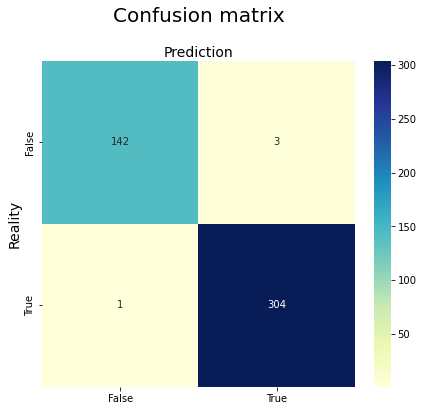

In [93]:
# Class names
fig, ax = plt.subplots(figsize=(7, 6))

# Heatmap creation
g = sns.heatmap(pd.DataFrame(cnf_matrix1), annot=True, cmap="YlGnBu", fmt='g')
ax.xaxis.set_label_position("top")
plt.title('Confusion matrix', y=1.1, fontsize=20)

#Axis
# Labels
ax.set_ylabel('Reality', fontsize=14)
ax.set_xlabel('Prediction', fontsize=14)

# Ticks
# Tick names
class_names=["False","True"]
#g.set(yticklabels=["Untrue","True"])
#g.set(xticklabels=["Untrue","True"])

# Tick positions
ax.tick_params(labelsize=10)
test = np.arange(len(class_names))
plt.xticks(test+0.5, class_names)
plt.yticks(test+0.5, class_names)

# We show the figure.
plt.show()

###### Indicators Confusion Matrix
**Indicators:**

*Accuracy:* The fraction of true positives and true negatives.

*Precision:* ratio true_positives/(true_positives + false_positives). The ability of the model not to positively label an individual who is negative.

*Sensitivity:* true_positive/(true_positive + false_negative) ratio. The ability of the model to find all positive individuals.

*Specificity:* ratio true_negatives/(true_negatives + false_positives). The ability of the model to find all negative individuals.

In [94]:
accuracy = round(metrics.accuracy_score(y_test, y_pred),2)
precision = round(metrics.precision_score(y_test, y_pred),2)
sensitivity = round(metrics.recall_score(y_test, y_pred),2)
specificity = round((cnf_matrix1[0,0]/(cnf_matrix1[0,0]+cnf_matrix1[0,1])),2)

In [95]:
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Sensitivity:", sensitivity)
print("Specificity:", specificity)

Accuracy: 0.99
Precision: 0.99
Sensitivity: 1.0
Specificity: 0.98


#### ROC Curve

**The receptor efficiency function**, more commonly referred to as **"the ROC curve"**, also known as the performance characteristic (of an assay) or the sensitivity/specificity curve, is a measure of the performance of a binary classifier.

Graphically, the ROC measurement is often represented in the form of a curve which gives the rate of true positives according to the rate of false positives.

**An AUC score** of 1 represents a perfect classifier, a score of 0.5 represents a useless classifier.

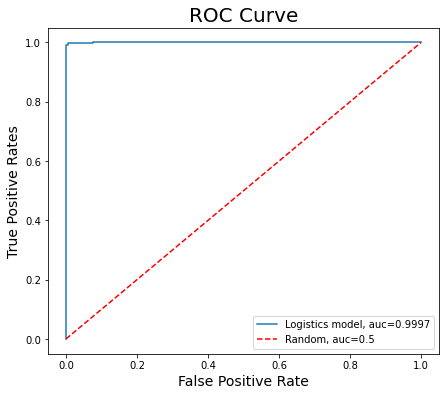

In [96]:
fig, ax = plt.subplots(figsize=(7, 6))
y_pred_proba = our_model1.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
auc = round(metrics.roc_auc_score(y_test, y_pred_proba),4)
plt.plot(fpr,tpr,label="Logistics model, auc="+str(auc))
x = [0,1]
y = [0,1]
plt.plot(x,y,"r--",label="Random, auc=0.5")
plt.legend(loc=4)


plt.title('ROC Curve', fontsize=20)

#Axis
# Labels
ax.set_ylabel('True Positive Rates', fontsize=14)
ax.set_xlabel('False Positive Rate', fontsize=14)
plt.show()

## Mission 3
### Classification analysis
#### K-means clustering

For all of our observations, we have a "true" observed value and a predicted "k_means" value.

**Clustering by K-means**

    - Faster
    - Not reproducible because choice of different centroids

In [97]:
# We exclude the "is_geniune" column.
# This is a view of data from the df_billet dataframe.
A = data.iloc[:,1:]

# Centering and Reduction
# "Standardize features by removing the mean and scaling to unit variance"
# fit "Compute the mean and std to be used for later scaling."
# std_scale.mean_ to see the mean of the variables
std_scale = StandardScaler().fit(A)

# Perform standardization by centering and scaling
# Contains our standardized values.
# we could have done fit_transform.
A_scaled = std_scale. transform(A)

In [98]:
n_clust = 2
km = KMeans(n_clusters=n_clust) #We create an object named "km" of the class KMeans
km.fit(A_scaled) #Compute k-means clustering.
# Retrieval of clusters assigned to each ticket
clusters = km.labels_
# Transformation of the values 0 and 1 into boolean False and True
# The first cluster "0" matches the first value.
# Let's look at the size of the two clusters to find out which is the one for the True values.
unique_values, count_of_unique_values = np.unique(clusters, return_counts=True)
# We select the cluster
cluster_true = [index for index in unique_values if count_of_unique_values[index] == max(count_of_unique_values)]
# We transform the list into an integer
cluster_true = cluster_true[0]
k_mean_result = [True if num == cluster_true else False for num in clusters]
# Recovery of centroids of clusters
centroids = np.array(km.cluster_centers_)

In [99]:
# We add a column to our dataframe to compare the results obtained.
data["k_mean"]=k_mean_result
data.head(10)

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length,k_mean
0,True,171.81,104.86,104.95,4.52,2.89,112.83,False
1,True,171.46,103.36,103.66,3.77,2.99,113.09,True
2,True,172.69,104.48,103.50,4.40,2.94,113.16,True
3,True,171.36,103.91,103.94,3.62,3.01,113.51,True
4,True,171.73,104.28,103.46,4.04,3.48,112.54,True
5,True,172.17,103.74,104.08,4.42,2.95,112.81,True
6,True,172.34,104.18,103.85,4.58,3.26,112.81,True
7,True,171.88,103.76,104.08,3.98,2.92,113.08,True
8,True,172.47,103.92,103.67,4.00,3.25,112.85,True
9,True,172.47,104.07,104.02,4.04,3.25,113.45,True


##### Indicators
**Indicators:**

*Accuracy:* The fraction of true positives and true negatives.

*Precision:* ratio true_positives/(true_positives + false_positives). The ability of the model not to positively label an individual who is negative.

*Sensitivity:* true_positive/(true_positive + false_negative) ratio. The ability of the model to find all positive individuals.

*Specificity:* ratio true_negatives/(true_negatives + false_positives). The ability of the model to find all negative individuals.

In [100]:
# To calculate our indicators and project individuals.
x_true_positive = data[(data["is_genuine"] & data["k_mean"])]
y_true_positive = data[(data["is_genuine"] & data["k_mean"])]

x_false_positive = data[(~data["is_genuine"] & data["k_mean"])]
y_false_positive = data[(~data["is_genuine"] & data["k_mean"])]

x_true_negative = data[(~data["is_genuine"] & (~data["k_mean"]))]
y_true_negative = data[(~data["is_genuine"] & (~data["k_mean"]))]

x_false_negative = data[(data["is_genuine"] & (~data["k_mean"]))]
y_false_negative = data[(data["is_genuine"] & (~data["k_mean"]))]

In [101]:
# We calculate the number of true/false positive/negative.
nb_true_positive = x_true_positive.shape[0]
nb_true_negative = x_true_negative.shape[0]
nb_false_positive = x_false_positive.shape[0]
nb_false_negative = x_false_negative.shape[0]

In [102]:
accuracy = round((nb_true_positive + nb_true_negative) / (nb_vrais + nb_faux),2)
precision = round(nb_true_positive / (nb_true_positive + nb_false_positive),2)
sensitivity = round(nb_true_positive / (nb_true_positive + nb_false_negative),2)
specificity = round(nb_true_negative / (nb_true_negative + nb_false_positive),2)

In [103]:
print("Accuracy:",accuracy)
print("Precision:",precision)
print("Sensitivity:",sensitivity)
print("Specificity:",specificity)

Accuracy: 0.98
Precision: 0.99
Sensitivity: 0.99
Specificity: 0.97


#### Visualisation

In [104]:
from sklearn import metrics

# We create an object of the metrics class.
cnf_matrix2 = metrics.confusion_matrix(data["is_genuine"], data["k_mean"])
cnf_matrix2

array([[486,  14],
       [ 10, 990]], dtype=int64)

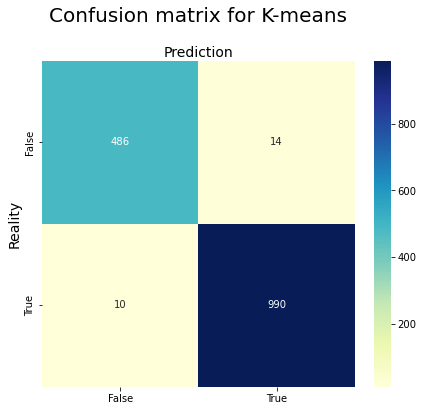

In [105]:
# Class names
fig, ax = plt.subplots(figsize=(7, 6))

# Heatmap creation
g = sns.heatmap(pd.DataFrame(cnf_matrix2), annot=True, cmap="YlGnBu", fmt='g')
ax.xaxis.set_label_position("top")
plt.title('Confusion matrix for K-means', y=1.1, fontsize=20)

#Axis
# Labels
ax.set_ylabel('Reality', fontsize=14)
ax.set_xlabel('Prediction', fontsize=14)

# Ticks
# Tick names
class_names=["False","True"]
#g.set(yticklabels=["Untrue","True"])
#g.set(xticklabels=["Untrue","True"])

# Tick positions
ax.tick_params(labelsize=10)
test = np.arange(len(class_names))
plt.xticks(test+0.5, class_names)
plt.yticks(test+0.5, class_names)

# We show the figure.
plt.show()

#### K-means clustering with PCA
##### Principal component analysis

    - Eigenvalue scree analysis
    - Representation of variables by the circle of correlations
    - Representation of individuals by factorial plans
    - Analyze the quality of representation and the contribution of individuals
    
##### Functions

In [106]:
def display_circles(pcs, n_comp, pca, axis_ranks, labels=None, label_rotation=0, lims=None):
    for d1, d2 in axis_ranks: # We display the first 3 factorial planes, therefore the first 6 components
        if d2 < n_comp:
            # determining the limits of the graph
            if lims is not None:
                xmin, xmax, ymin, ymax = lims
            elif pcs.shape[1] < 30: # If we have less than 30 arrows.
                xmin, xmax, ymin, ymax = -1, 1, -1, 1
            else: # Otherwise we adjust according to the value of the arrows.
                xmin, xmax, ymin, ymax = min(pcs[d1,:]), max(pcs[d1,:]), min(pcs[d2,:]), max(pcs[d2,:])

            # display arrows
            # https://matplotlib.org/api/_as_gen/matplotlib.pyplot.quiver.html
            # if there are more than 30 arrows, the triangle is not displayed at their end
            if pcs.shape[1] < 30:
                plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]), # origin of arrows
                   pcs[d1,:], pcs[d2,:], # Arrow destinations.
                   angles='xy', scale_units='xy', scale=1, color="grey")
            #arrow angle #scale_unit length of the arrow.
            else:
                lines = [[[0,0],[x,y]] for x,y in pcs[[d1,d2]].T]
                ax.add_collection(LineCollection(lines, axes=ax, alpha=.1, color='black'))
            
            # display variable names
            if labels is not None:
                for i,(x, y) in enumerate(pcs[[d1,d2]].T):
                    if x >= xmin and x <= xmax and y >= ymin and y <= ymax:
                        plt.text(x, y, labels[i], fontsize='14', ha='center', va='center', rotation=label_rotation, color="blue", alpha=0.5)
            
            # circle display
            circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='b')
            plt.gca().add_artist(circle)

            # set graph limits
            plt.xlim(xmin, xmax)
            plt.ylim(ymin, ymax)
        
            # display horizontal and vertical lines
            plt.plot([-1, 1], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-1, 1], color='grey', ls='--')

            # names of the axes, with the percentage of inertia explained
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Circle of correlations (F{} and F{})".format(d1+1, d2+1))
            plt.show(block=False)
def display_scree_plot(pca):
    scree = pca.explained_variance_ratio_*100
    plt.bar(np.arange(len(scree))+1, scree)
    plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="red",marker='o')
    plt.xlabel("axis of inertia rank")
    plt.ylabel("inertia percentage")
    plt.title("Scree of eigenvalues")
    plt.show(block=False)

##### Preparing data for PCA

**Components:** We have 6 main components.

**Individuals:** We have 1500 individuals/banknotes.

**Illustrative variable:** the "true" variable giving the True/False nature of the ticket.

Illustrative variables do not influence the construction of the principal components of the analysis. They help in the interpretation of the dimensions of variability.

In [107]:
# Data for PCA.
# We exclude the "veracite" column.
# This is a view of data from the df_billet dataframe.
X = data.iloc[:,1:7]

# Centering and Reduction
# "Standardize features by removing the mean and scaling to unit variance"
# fit "Compute the mean and std to be used for later scaling."
# std_scale.mean_ to see the mean of the variables
std_scale = StandardScaler().fit(X)

# Perform standardization by centering and scaling
# Contains our standardized values.
# we could have done fit_transform.
X_scaled = std_scale.transform(X)

In [108]:
# We create an object of the PCA class.
#fit(): Fit the model with X.
# n_components = None we keep all the variables.
pca = PCA(n_components=None).fit(X_scaled)

# transform: Apply dimensionality reduction to X.
# We go from 7 dimensions to 2 dimensions.
X_projected = pca.transform(X_scaled)

# Directions of principal components.
pcs = pca.components_

In [109]:
# The component names
# We have an array.
column_names = X.columns
components = np.array(column_names)

# Colors that we are going to use to color each point according to its truthfulness.
color = plt.get_cmap('tab10')

# We record the veracity of the banknotes
tickets = data.iloc[:, 0].values

#### Eigenvalue scree

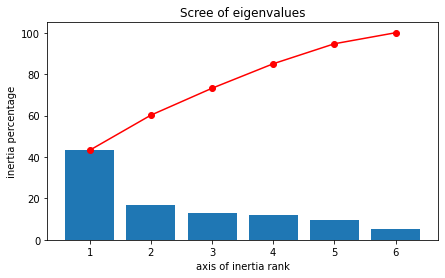

In [110]:
# Eigenvalue scree
# figure initialization
fig, ax = plt.subplots(figsize=(7,4))

display_scree_plot(pca)

In [111]:
# The percentage of variance explained by each component or axis (F1, F2,...)
# Similar to eigenvalue scree.
pca.explained_variance_ratio_

array([0.43211292, 0.16957177, 0.1301927 , 0.11824046, 0.09663102,
       0.05325112])

### Circle of correlations
Premier plan factoriel

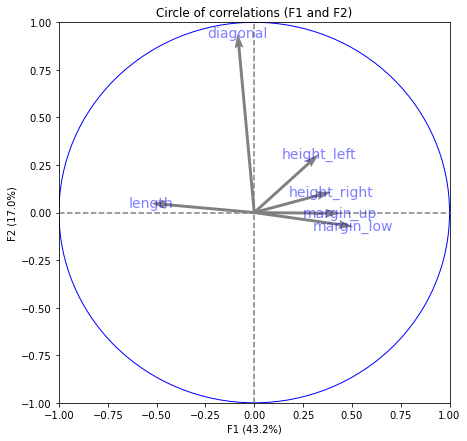

In [112]:
# Circle of correlations
# figure initialization
fig, ax = plt.subplots(figsize=(7,7))
display_circles(pcs, 4, pca, [(0,1)], labels=components)

Deuxième plan factoriel

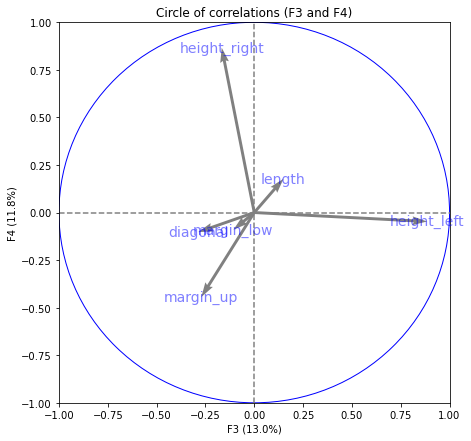

In [113]:
# Circle of correlations
# figure initialization
fig, ax = plt.subplots(figsize=(7,7))
display_circles(pcs, 4, pca, [(2,3)], labels=components)

### Representation of individuals

Wishing to project in two different colors our true banknotes and our false banknotes, we must:

    - Select data from X_projected
    - When the ticket is true
    - When the ticket is not true

**Premier Plan Factoriel**

In [114]:
# Axes associated with this plane
axis_ranks = [(0,1)]

In [115]:
for d1, d2 in axis_ranks:
    x_true = X_projected[:,d1][data["is_genuine"]]
    y_true = X_projected[:,d2][data["is_genuine"]]
    x_false = X_projected[:,d1][~data["is_genuine"]]
    y_false = X_projected[:,d2][~data["is_genuine"]]

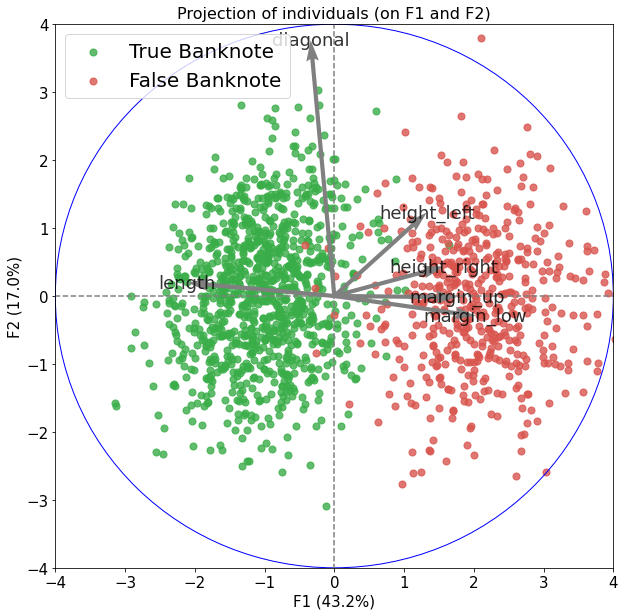

In [116]:
# Projection of individuals
# The factorial plane that we want to see
# Axes associated with this plane
axis_ranks = [(0,1)]

# figure initialization
fig, ax = plt.subplots(figsize=(10,10))
ax.tick_params(labelsize=15)

for d1,d2 in axis_ranks:
    ax.scatter(x_true,y_true, c=green, alpha=.8, label="True Banknote",s=50)
    ax.scatter(x_false,y_false, c=red, alpha=.8, label="False Banknote",s=50)
    # s size marker. # Label for the caption
        
    legend = ax.legend(fontsize=20)

    # determining the limits of the graph
    # We will base the circle on these measurements so we must lim_x = lim_y
    graph_lim = 4
    plt.xlim([-graph_lim,graph_lim]) #-boundary,boundary
    plt.ylim([-graph_lim,graph_lim]) #-boundary,boundary
    
    # display horizontal and vertical lines
    plt.plot([-100, 100], [0, 0], color='grey', ls='--')
    plt.plot([0, 0], [-100, 100], color='grey', ls='--')

    # names of the axes, with the percentage of inertia explained
    plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)), fontsize=15)
    plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)), fontsize=15)
    
    plt.title("Projection of individuals (on F{} and F{})".format(d1+1, d2+1), fontsize=16)
    
    
    # display component names
    labels = components
    for i,(x, y) in enumerate(pcs[[d1,d2]].T):
        plt.text(x*graph_lim, y*graph_lim, labels[i], fontsize='18', ha='center', va='center', color="black", alpha=0.8)
    
    # display arrows
    # https://matplotlib.org/api/_as_gen/matplotlib.pyplot.quiver.html
    plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]), # origin of arrows
       pcs[d1,:]*graph_lim, pcs[d2,:]*graph_lim, # Arrow destinations.
       angles='xy', scale_units='xy', scale=1, color="grey")
    #arrow angle #scale_unit length of the arrow.
    
    # circle display
    circle = plt.Circle((0,0), 1*graph_lim, facecolor='none', edgecolor='b')
    plt.gca().add_artist(circle)

plt.show(block=False)

In [117]:
# Correlation between main FX components and variables.
# components = names of explanatory columns.
# pca_components_: correlation matrix.
correlation_matrix = pd.DataFrame(pca.components_, columns=components, index = ['F1','F2','F3','F4','F5','F6'])
print(correlation_matrix)

    diagonal  height_left  height_right  margin_low  margin_up    length
F1 -0.084871     0.331344      0.393813    0.506668   0.439249 -0.527511
F2  0.941328     0.307220      0.108539   -0.073138  -0.004377  0.048659
F3 -0.286821     0.884771     -0.166563   -0.106406  -0.271006  0.149682
F4 -0.102750    -0.047091      0.866279   -0.090116  -0.444095  0.177326
F5 -0.117519     0.103712      0.234376   -0.570846   0.709671  0.301665
F6  0.007954     0.005894      0.004055    0.626602   0.180949  0.757966


#### Deuxième plan factoriel

In [118]:
# Axes associated with this plane
axis_ranks = [(2,3)]

In [119]:
for d1, d2 in axis_ranks:
    x_true = X_projected[:,d1][data["is_genuine"]]
    y_true = X_projected[:,d2][data["is_genuine"]]
    x_false = X_projected[:,d1][~data["is_genuine"]]
    y_false = X_projected[:,d2][~data["is_genuine"]]

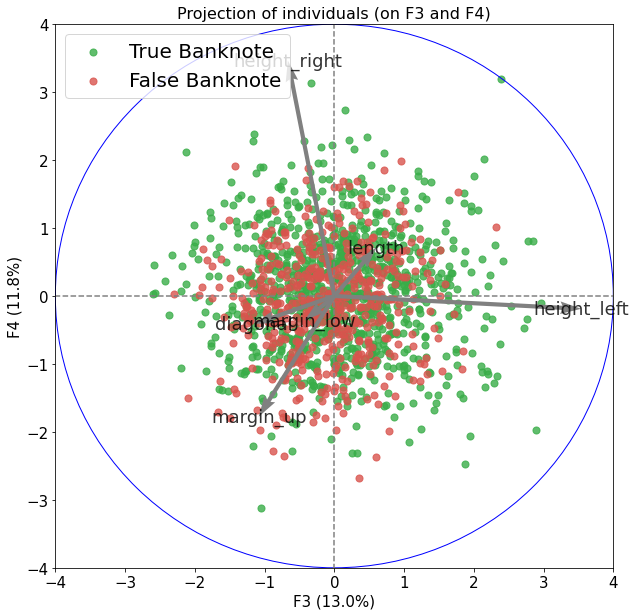

In [120]:
# Projection of individuals
# The factorial plane that we want to see
# figure initialization
fig, ax = plt.subplots(figsize=(10,10))
ax.tick_params(labelsize=15)

for d1,d2 in axis_ranks:
    ax.scatter(x_true,y_true, c=green, alpha=.8, label="True Banknote",s=50)
    ax.scatter(x_false,y_false, c=red, alpha=.8, label="False Banknote",s=50)
    # s size marker. # Label for the caption
        
    legend = ax.legend(fontsize=20)

    # determining the limits of the graph
    # We will base the circle on these measurements so we must lim_x = lim_y
    graph_lim = 4
    plt.xlim([-graph_lim,graph_lim]) #-boundary,boundary
    plt.ylim([-graph_lim,graph_lim]) #-boundary,boundary
    
    # display horizontal and vertical lines
    plt.plot([-100, 100], [0, 0], color='grey', ls='--')
    plt.plot([0, 0], [-100, 100], color='grey', ls='--')

    # names of the axes, with the percentage of inertia explained
    plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)), fontsize=15)
    plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)), fontsize=15)
    
    plt.title("Projection of individuals (on F{} and F{})".format(d1+1, d2+1), fontsize=16)
    
    
    # display component names
    labels = components
    for i,(x, y) in enumerate(pcs[[d1,d2]].T):
        plt.text(x*graph_lim, y*graph_lim, labels[i], fontsize='18', ha='center', va='center', color="black", alpha=0.8)
    
    # display arrows
    # https://matplotlib.org/api/_as_gen/matplotlib.pyplot.quiver.html
    plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]), # origin of arrows
       pcs[d1,:]*graph_lim, pcs[d2,:]*graph_lim, # Arrow destinations.
       angles='xy', scale_units='xy', scale=1, color="grey")
    #arrow angle #scale_unit length of the arrow.
    
    # circle display
    circle = plt.Circle((0,0), 1*graph_lim, facecolor='none', edgecolor='b')
    plt.gca().add_artist(circle)

**Analysis of the quality of representation and the contribution of individuals**

*Quality of representation:*

In the first factorial plane, we can see that the individuals are well represented because they are grouped by color. Moreover, the axes F1 and F2 explain a large part of the percentage of inertia (43.2% and 17%).

In the second factorial plane, this is no longer the case.
This is why we will only interpret the projection of individuals in the first factorial plane.

*Contribution of individuals:*

When calculating the principal components, each individual is taken into account.

However, some influence the calculation of certain components more than others.

It sometimes happens that an axis is mainly due to a very small group of individuals, or even just one. This means that a few individuals "pull" an axis strongly in their direction, almost without letting other individuals contribute to the formation of this axis.

However, this is not our case. Indeed, we have no point or outlier with values ​​such that they alone attract the axes. This can be seen via the projection of individuals.

In [121]:
pca.singular_values_ 

array([62.36197805, 39.06591772, 34.23060503, 32.62152925, 29.49032311,
       21.89201038])

##### Clustering K-means

In [122]:
n_clust = 2
km = KMeans(n_clusters=n_clust) #We create an object named "km" of the class KMeans
km.fit(X_scaled) #Compute k-means clustering.
# Retrieval of clusters assigned to each ticket
clusters = km.labels_
# Transformation of the values 0 and 1 into boolean False and True
# The first cluster "0" matches the first value.
# Let's look at the size of the two clusters to find out which is the one for the True values.
unique_values, count_of_unique_values = np.unique(clusters, return_counts=True)
# We select the cluster
cluster_true = [index for index in unique_values if count_of_unique_values[index] == max(count_of_unique_values)]
# We transform the list into an integer
cluster_true = cluster_true[0]
k_mean_result = [True if num == cluster_true else False for num in clusters]
# Recovery of centroids of clusters before reducing dimensions.
centroids = np.array(km.cluster_centers_)

In [123]:
# We add a column to our dataframe to compare the results obtained.
data["k_mean with PCA"]=k_mean_result
data.head(10)

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length,k_mean,k_mean with PCA
0,True,171.81,104.86,104.95,4.52,2.89,112.83,False,False
1,True,171.46,103.36,103.66,3.77,2.99,113.09,True,True
2,True,172.69,104.48,103.50,4.40,2.94,113.16,True,True
3,True,171.36,103.91,103.94,3.62,3.01,113.51,True,True
4,True,171.73,104.28,103.46,4.04,3.48,112.54,True,True
5,True,172.17,103.74,104.08,4.42,2.95,112.81,True,True
6,True,172.34,104.18,103.85,4.58,3.26,112.81,True,True
7,True,171.88,103.76,104.08,3.98,2.92,113.08,True,True
8,True,172.47,103.92,103.67,4.00,3.25,112.85,True,True
9,True,172.47,104.07,104.02,4.04,3.25,113.45,True,True


In [124]:
# To calculate our indicators and project individuals.
x_true_positive = X_projected[:,0][(data["is_genuine"] & data["k_mean with PCA"])]
y_true_positive = X_projected[:,1][(data["is_genuine"] & data["k_mean with PCA"])]

x_false_positive = X_projected[:,0][(~data["is_genuine"] & data["k_mean with PCA"])]
y_false_positive = X_projected[:,1][(~data["is_genuine"] & data["k_mean with PCA"])]

x_true_negative = X_projected[:,0][(~data["is_genuine"] & (~data["k_mean with PCA"]))]
y_true_negative = X_projected[:,1][(~data["is_genuine"] & (~data["k_mean with PCA"]))]

x_false_negative = X_projected[:,0][(data["is_genuine"] & (~data["k_mean with PCA"]))]
y_false_negative = X_projected[:,1][(data["is_genuine"] & (~data["k_mean with PCA"]))]

In [125]:
# We calculate the number of true/false positive/negative.
nb_true_positive = x_true_positive.shape[0]
nb_true_negative = x_true_negative.shape[0]
nb_false_positive = x_false_positive.shape[0]
nb_false_negative = x_false_negative.shape[0]

In [126]:
accuracy = round((nb_true_positive + nb_true_negative) / (nb_vrais + nb_faux),2)
precision = round(nb_true_positive / (nb_true_positive + nb_false_positive),2)
sensitivity = round(nb_true_positive / (nb_true_positive + nb_false_negative),2)
specificity = round(nb_true_negative / (nb_true_negative + nb_false_positive),2)

In [127]:
print("Accuracy:",accuracy)
print("Precision:",precision)
print("Sensitivity:",sensitivity)
print("Specificity:",specificity)

Accuracy: 0.98
Precision: 0.99
Sensitivity: 0.99
Specificity: 0.97


### Visualisation

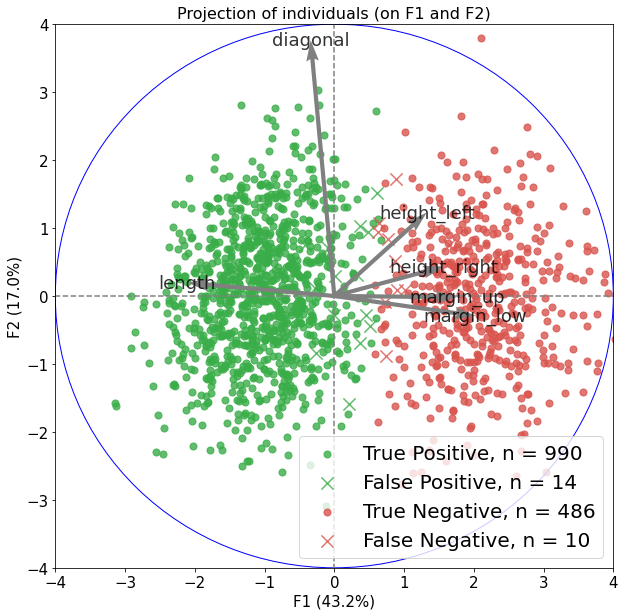

In [128]:
# Projection of individuals
# The factorial plane that we want to see
# Axes associated with this plane
axis_ranks = [(0, 1)]

# figure initialization
fig, ax = plt. subplots(figsize=(10, 10))
ax.tick_params(labelsize=15)

for d1, d2 in axis_ranks:
    ax.scatter(x_true_positive, y_true_positive, c=green, alpha=.8,
               label="True Positive, n = {}".format(nb_true_positive), s=50)
    ax.scatter(x_false_positive, y_false_positive, c=green, alpha=.8,
               marker="x", label="False Positive, n = {}".format(nb_false_positive), s=150)
    ax.scatter(x_true_negative, y_true_negative, c=red,
               alpha=.8, label="True Negative, n = {}".format(nb_true_negative), s=50)
    ax.scatter(x_false_negative, y_false_negative, c=red,
               alpha=.8, marker="x", label="False Negative, n = {}".format(nb_false_negative), s=150)
    # s size marker. # Label for the caption

    legend = ax.legend(fontsize=20)

    # determining the limits of the graph
    # We will base the circle on these measurements so we must lim_x = lim_y
    graph_lim = 4
    plt.xlim([-graph_lim, graph_lim]) # -boundary,boundary
    plt.ylim([-graph_lim, graph_lim]) # -boundary,boundary

    # display horizontal and vertical lines
    plt.plot([-100, 100], [0, 0], color='grey', ls='--')
    plt.plot([0, 0], [-100, 100], color='grey', ls='--')

    # names of the axes, with the percentage of inertia explained
    plt.xlabel('F{} ({}%)'.format(
        d1+1, round(100*pca.explained_variance_ratio_[d1], 1)), fontsize=15)
    plt.ylabel('F{} ({}%)'.format(
        d2+1, round(100*pca.explained_variance_ratio_[d2], 1)), fontsize=15)

    plt.title("Projection of individuals (on F{} and F{})".format(
        d1+1, d2+1), fontsize=16)

    # display component names
    labels = components
    for i, (x, y) in enumerate(pcs[[d1, d2]].T):
        plt.text(x*graph_lim, y*graph_lim,
                 labels[i], fontsize='18', ha='center', va='center', color="black", alpha=0.8)

    # display arrows
    # https://matplotlib.org/api/_as_gen/matplotlib.pyplot.quiver.html
    plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]), # origin of arrows
               # Arrow destinations.
               pcs[d1,:]*graph_lim, pcs[d2,:]*graph_lim,
               angles='xy', scale_units='xy', scale=1, color="grey")
    # angle of the arrows #scale_unit length of the arrow.

    # circle display
    circle = plt.Circle((0, 0), 1*graph_lim, facecolor='none', edgecolor='b')
    plt.gca().add_artist(circle)

plt.show(block=False)

#### K-NN

Using the k-nearest neighbor algorithm we fit the data (or train the model) and predict the future

**Following steps are performed:**

    - Create explanatory and explained variables
    - Split data into training and test data
    - Generate a k-NN model using neighbors' value
    - Train or fit the data into the model
    - Predict the future

### Data preparation
#### Explanatory variables vs Explained variable

In [129]:
from sklearn.neighbors import KNeighborsClassifier

# Explanatory variables
X = data.iloc[:,1:7]
# Variables explained
y = data['is_genuine']

### Data separation
#### Separation of data between:

- The data to train our model, 70% of our data.
- Data to test our model, 30% of our data.

In [130]:
# Split into training and test set
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size = 0.3, random_state=100)

#### Model development and prediction

In [131]:
# We create an object of the K-NN class.
knn = KNeighborsClassifier(n_neighbors=2)

In [132]:
# We create our model.
# We train it with our training data
y_train = pd.DataFrame(y_train)

y_train_array = y_train.iloc[:,0].values
knn.fit(X_train, y_train_array)

KNeighborsClassifier(n_neighbors=2)

In [133]:
# We make the prediction
# with .predict()
y_pred = knn.predict(X_test)

### Model evaluation
#### Confusion Matrix
- Table to visualize the performance of our model. It understands:

                                The number of correct predictions
                                The number of incorrect predictions


In [134]:
# We create an object of the metrics class.
cnf_matrix3 = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix3

array([[143,   2],
       [  5, 300]], dtype=int64)

### Heat Map
We visualize this table with a heatmap

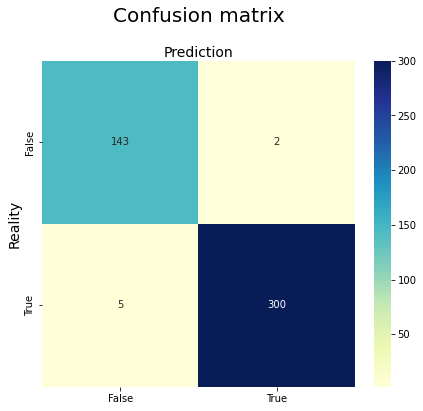

In [135]:
# Class names
fig, ax = plt.subplots(figsize=(7, 6))

# Heatmap creation
g = sns.heatmap(pd.DataFrame(cnf_matrix3), annot=True, cmap="YlGnBu", fmt='g')
ax.xaxis.set_label_position("top")
plt.title('Confusion matrix', y=1.1, fontsize=20)

#Axis
# Labels
ax.set_ylabel('Reality', fontsize=14)
ax.set_xlabel('Prediction', fontsize=14)

# Ticks
# Tick names
class_names=["False","True"]
#g.set(yticklabels=["Untrue","True"])
#g.set(xticklabels=["Untrue","True"])

# Tick positions
ax.tick_params(labelsize=10)
test = np.arange(len(class_names))
plt.xticks(test+0.5, class_names)
plt.yticks(test+0.5, class_names)

# We show the figure.
plt.show()

#### Indicators Confusion Matrix
**Indicators:**

*Accuracy:* The fraction of true positives and true negatives.

*Precision:* ratio true_positives/(true_positives + false_positives). The ability of the model not to positively label an individual who is negative.

*Sensitivity:* true_positive/(true_positive + false_negative) ratio. The ability of the model to find all positive individuals.

*Specificity:* ratio true_negatives/(true_negatives + false_positives). The ability of the model to find all negative individuals.

In [136]:
accuracy = round(metrics.accuracy_score(y_test, y_pred),2)
precision = round(metrics.precision_score(y_test, y_pred),2)
sensitivity = round(metrics.recall_score(y_test, y_pred),2)
specificity = round((cnf_matrix3[0,0]/(cnf_matrix3[0,0]+cnf_matrix3[0,1])),2)

In [137]:
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Sensitivity:", sensitivity)
print("Specificity:", specificity)

Accuracy: 0.98
Precision: 0.99
Sensitivity: 0.98
Specificity: 0.99


In [138]:
# Calculate the accuracy of the model
print(knn.score(X_test, y_test))

0.9844444444444445


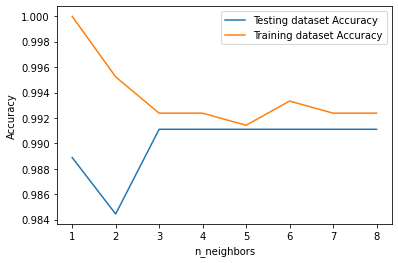

In [139]:
neighbors = np.arange(1, 9)
train_accuracy = np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))
 
# Loop over K values
for i, k in enumerate(neighbors):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train.values.ravel())
     
    # Compute training and test data accuracy
    train_accuracy[i] = knn.score(X_train, y_train)
    test_accuracy[i] = knn.score(X_test, y_test)
    
# Generate Plot
plt.plot(neighbors, test_accuracy, label = 'Testing dataset Accuracy')
plt.plot(neighbors, train_accuracy, label = 'Training dataset Accuracy')
 
plt.legend()
plt.xlabel('n_neighbors')
plt.ylabel('Accuracy')
plt.show()

### Program to make a prediction on a ticket
For each ticket, the classification algorithm will have to give the probability that the ticket is true. If this probability is greater than or equal to 0.5, the ticket will be considered true. Otherwise, it will be considered false.

In [140]:
#example
file_name_to_predict = "billets_production.csv"

In [141]:
df_data = pd.read_csv(file_name_to_predict)
df_data

,diagonal,height_left,height_right,margin_low,margin_up,length,id
0,171.76,104.01,103.54,5.21,3.30,111.42,A_1
1,171.87,104.17,104.13,6.00,3.31,112.09,A_2
2,172.00,104.58,104.29,4.99,3.39,111.57,A_3
3,172.49,104.55,104.34,4.44,3.03,113.20,A_4
4,171.65,103.63,103.56,3.77,3.16,113.33,A_5


In [142]:
# Data for prediction
X_to_predict = df_data.iloc[:, 0:6]

# Prediction with our model.
y_pred = our_model.predict(X_to_predict)
true_probability = our_model.predict_proba(X_to_predict)[:, 1]

# Adding a column with the probability that the sample is true according to the prediction
df_data["true_probability"] = np.round(true_probability, 2)

# Adding a column with the prediction
df_data["true_prediction"] = y_pred

In [143]:
df_data

,diagonal,height_left,height_right,margin_low,margin_up,length,id,true_probability,true_prediction
0,171.76,104.01,103.54,5.21,3.30,111.42,A_1,0.01,False
1,171.87,104.17,104.13,6.00,3.31,112.09,A_2,0.00,False
2,172.00,104.58,104.29,4.99,3.39,111.57,A_3,0.00,False
3,172.49,104.55,104.34,4.44,3.03,113.20,A_4,0.91,True
4,171.65,103.63,103.56,3.77,3.16,113.33,A_5,1.00,True
